In [1]:
# Imports
%load_ext autoreload
%autoreload 2
from astropy.coordinates import Distance
import bilby
from gwBackground import *
import math
import matplotlib 
import matplotlib.pyplot as plt
import numpy as np
import os
# from pygwb.constants import H0
from pygwb.detector import Interferometer
from pygwb.network import Network
from pygwb.parameters import Parameters
from pygwb.baseline import Baseline
from pygwb.simulator import Simulator
import scipy
from scipy.integrate import trapz
from scipy.integrate import cumtrapz
from scipy.special import erfinv
import sys
sys.path.append('../code/')
from tqdm import tqdm

In [2]:
# Plot formatting
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
fontsize = 9
params = {
   'axes.labelsize': fontsize,
   'font.size': fontsize,
   'legend.fontsize': 8,
   'xtick.labelsize': fontsize,
   'ytick.labelsize': fontsize,
   'axes.titlesize':fontsize,
   'lines.linewidth':1,  
   'xtick.direction':'in',
   'ytick.direction':'in',
   'font.family':'Serif',
   'font.serif':'Hoefler Text',
   'axes.grid':True,
   'figure.figsize': (6.75, 4),
   'figure.dpi':250,
   'mathtext.fontset':'cm'
}

for param in params.keys():
    matplotlib.rcParams[param] = params[param]  

In [3]:
# Constants
# Fundamental Constants
G = 6.6743015e-11 # Gravitational constant (in m^3 kg^-1 s^-2)
c = 2.99792458e8 # Speed of light (in m s^-1)

# Unit Conversions
km = 1e3 # km --> m
Mpc = 3.08567758128e22 # Mpc --> m
Gpc = 3.08567758128e25 # Gpc --> m
Msun = 1.989e30 # Msun --> kg
MsunToSec = Msun*G/np.power(c,3.)
yr = 60*60*24*365.25 # yr --> s

# Merger Rate Constants
alpha = 1.9 # spectral index before peak zp
beta = 3.4 # spectral index after peak zp
zp = 2.4 # peak redshift of merger rate
R0 = 28.3 # current merger rate (in Gpc^-3 yr^-1)

# Redshift Parameters
dz = 0.01 # redshift bin step size
z_max = 10 # maximum plausible redshift

# Hubble Rate Constants
H0 = 67.4 # Hubble constant (Hubble rate at z = 0) (in km s^-1 Mpc^-1)
omegaR = 9.182e-5 # radiation component of energy density
omegaM = 0.3111 # matter component of energy density
omegak = 0 # spacetime curvature component of energy density
omegaL = 0.6889 # dark energy component of energy density, cosmological constant

# Mass Parameters
BBH_min = 5 # minimum BBH mass
BBH_max = 44 # maximum BBH mass

# Frequency Parameters
eta = 0.25
fmax = 3000
fref = 25

# Data Simulation Parameters
T_obs = (1/365.25/24) # observation time (in yrs)
duration = T_obs*60*60*24*365.25 # duration of each segment of data (in s)
N_segs = 1 # number of data segments to generate
fs = 2048 # sampling rate (in Hz)

In [4]:
# Equations
def pc(H0):
    '''
    Equation from Renzini et al. 2022.
    Calculates the critical energy density.
    
    Parameters
    ----------
    H0 : double
        Hubble constant (km s^-1 Mpc^-1)
        
    Returns
    -------
    double
        critical energy density (in km kg s Mpc^-1 m^-3)
    '''
    return 3*(H0*c)**2/(8*math.pi*G)

def pc_SI(H0):
    '''
    Equation from Renzini et al. 2022.
    Calculates the critical energy density.
    
    Parameters
    ----------
    H0 : double
        Hubble constant (in km s^-1 Mpc^-1)
        
    Returns
    -------
    double
        critical energy density (in kg m^-3)
    '''
    H0 = H0*km/Mpc # convert to Hz
    return 3*(H0*c)**2/(8*math.pi*G)

def R(alpha, beta, z, zp, R0):
    '''
    Equation from Callister et al. 2020.
    Calculates the merger rate at a given redshift.
    
    Parameters
    ----------
    alpha : double
        spectral index before peak zp
    beta : double
        spectral index after peak zp
    z : double
        redshift
    zp : double
        peak redshift of merger rate
    R0 : double
        current merger rate (z = 0) (Gpc^- 3 yr^-1)
        
    Returns
    -------
    double
        merger rate at the given redshift (in Gpc^-3 yr^-1)
    '''
    return C(alpha, beta, zp)*R0 * (1+z)**alpha / (1 + (1+z)/(1+zp)**(alpha+beta))

def R_SI(alpha, beta, z, zp, R0):
    '''
    Equation from Callister et al. 2020.
    Calculates the merger rate at a given redshift.
    
    Parameters
    ----------
    alpha : double
        spectral index before peak z_p
    beta : double
        spectral index after peak z_p
    z : double
        redshift
    zp : double
        peak redshift of merger rate
    R0 : double
        current merger rate (z = 0) (Gpc^-3 yr^-1)
        
    Returns
    -------
    double
        merger rate at the given redshift (in Hz m^-3)
    '''
    R0 = R0/Gpc**3/yr # convert to m^-3 s^-1 = m^-3 Hz
    return C(alpha, beta, zp)*R0 * (1+z)**alpha / (1 + ((1+z)/(1+zp))**(alpha+beta))

def C(alpha, beta, zp):
    '''
    Equation from Callister et al. 2020.
    Calculates the normalization constant for the merger rate.
    
    Parameters
    ----------
    alpha : double
        spectral index before peak z_p
    beta : double
        spectral index after peak z_p
    zp : double
        peak redshift of merger rate
    
    Returns
    -------
    double
        normalization constant for the merger rate
    '''
    return 1 + (1+zp)**(-alpha-beta)

def Hubble_rate(z, H0, omegaR, omegaM, omegak, omegaL):
    '''
    Equation from Renzini et al. 2022.
    Calculates the Hubble rate as a function of redshift.
    
    Parameters
    ----------
    z : double
        redshift
    H0 : double
        Hubble constant (Hubble rate at z = 0) (in km s^-1 Mpc^-1)
    omegaR : double
        radiation component of energy density
    omegaM : double
        matter component of energy density
    omegak : double
        spacetime curvature component of energy density
    omegaL : double
        dark energy component of energy density, cosmological constant
    
    Returns
    -------
    double
        Hubble rate for a given redshift z (in km s^-1 Mpc^-1)
    '''
    return H0*(omegaR*(1+z)**4 + omegaM*(1+z)**3 + omegak*(1+z)**2 + omegaL)**(1/2)

def Hubble_rate_SI(z, H0, omegaR, omegaM, omegak, omegaL):
    '''
    Equation from Renzini et al. 2022.
    Calculates the Hubble rate as a function of redshift.
    
    Parameters
    ----------
    z : double
        redshift
    H0 : double
        Hubble constant (Hubble rate at z = 0) (in km s^-1 Mpc^-1)
    omegaR : double
        radiation component of energy density
    omegaM : double
        matter component of energy density
    omegak : double
        spacetime curvature component of energy density
    omegaL : double
        dark energy component of energy density, cosmological constant
    
    Returns
    -------
    double
        Hubble rate for a given redshift z (in Hz m^-3)
    '''
    H0 = H0*km/Mpc # convert to Hz
    return H0*(omegaR*(1+z)**4 + omegaM*(1+z)**3 + omegak*(1+z)**2 + omegaL)**(1/2)

def ave_dEdf(f, Mtots, events):
    '''
    Equation from Renzini et al. 2022.
    Sums the spectral energy density of individual events with a given set of parameters.
    
    Parameters
    ----------
    f : double
        frequency (in Hz)
    f_merge : double
        merger frequency (in Hz)
    f_ring : double
        ringdown frequency (in Hz)
    f_cutoff : double
        cutoff frequency (in Hz)
    sigma : double
        width of Lorentzian function around f_ring (in Hz)
    events : List<double>
        list of events (chirp masses) that incorporates the mass distribution (in Solar masses)
        
    Returns
    -------
    double
        average spectral density
    '''
    total_sum = 0
    for i in range(len(events)):
        Mtot = Mtots[i]
        M = events[i]
        value = dEdf(M, f, Mtot)
        total_sum += value
    return total_sum

def ave_dEdf_SI(f, Mtots, events):
    '''
    Equation from Renzini et al. 2022.
    Sums the spectral energy density of individual events with a given set of parameters.
    
    Parameters
    ----------
    f : double
        frequency (in Hz)
    f_merge : double
        merger frequency (in Hz)
    f_ring : double
        ringdown frequency (in Hz)
    f_cutoff : double
        cutoff frequency (in Hz)
    sigma : double
        width of Lorentzian function around f_ring (in Hz)
    events : List<double>
        list of events (chirp masses) that incorporates the mass distribution (in Solar masses)
        
    Returns
    -------
    double
        average spectral density
    '''
    total_sum = 0
    for i in range(len(events)):
        Mtot = Mtots[i]
        M = events[i]
        value = dEdf_SI(M, f, Mtot)
        total_sum += value
    return total_sum

def dEdf(M, f, Mtot):
    '''
    Equation from Callister et al. 2016.
    Calculates the spectral energy density for a single event.
    
    Parameters
    ----------
    M : double
        chirp mass (in Solar masses)
    f : double
        frequency (in Hz)
    f_merge : double
        merger frequency (in Hz)
    f_ring : double
        ringdown frequency (in Hz)
    f_cutoff : double
        cutoff frequency (in Hz)
    sigma : double
        width of Lorentzian function around f_ring (in Hz)
        
    Returns
    -------
    double
        spectral energy density for a given chirp mass and frequency (in m^2 Hz Msun^5/3 kg^-2/3)
    '''
    return (G*math.pi)**(2/3) * M**(5/3) * H(f, Mtot)/3

def dEdf_SI(M, f, Mtot):
    '''
    Equation from Callister et al. 2016.
    Calculates the spectral energy density for a single event.
    
    Parameters
    ----------
    M : double
        chirp mass (in Solar masses)
    f : double
        frequency (in Hz)
    f_merge : double
        merger frequency (in Hz)
    f_ring : double
        ringdown frequency (in Hz)
    f_cutoff : double
        cutoff frequency (in Hz)
    sigma : double
        width of Lorentzian function around f_ring (in Hz)
        
    Returns
    -------
    double
        spectral energy density for a given chirp mass and frequency (in m^2 kg Hz)
    '''
    M *= Msun # convert to kg
    dEdf = (G*math.pi)**(2/3) * M**(5/3) * H(f, Mtot)/3
    return dEdf

def H(f, Mtot):
    '''
    Equation from Callister et al. 2016.
    Calculates H for a given frequency.
    
    Parameters
    ----------
    f : double
        frequency (in Hz)
    f_merge : double
        merger frequency (in Hz)
    f_ring : double
        ringdown frequency (in Hz)
    f_cutoff : double
        cutoff frequency (in Hz)
    sigma : double
        width of Lorentzian function around f_ring (in Hz)
        
    Returns
    -------
    double
        H(f) (in Hz^-1/3)
    '''
    # Parameters from Tom Callister
    # Waveform model from Ajith+ 2008 (10.1103/PhysRevD.77.104017)
    # Define IMR parameters
    # See Eq. 4.19 and Table 1
    f_merge = (0.29740*eta**2. + 0.044810*eta + 0.095560)/(np.pi*Mtot*MsunToSec)
    f_ring = (0.59411*eta**2. + 0.089794*eta + 0.19111)/(np.pi*Mtot*MsunToSec)
    f_cutoff = (0.84845*eta**2. + 0.12828*eta + 0.27299)/(np.pi*Mtot*MsunToSec)
    sigma = (0.50801*eta**2. + 0.077515*eta + 0.022369)/(np.pi*Mtot*MsunToSec)
    
    if f < f_merge:
        return f**(-1/3)
    elif f >= f_merge and f < f_ring:
        return f**(2/3)/f_merge
    elif f >= f_ring and f < f_cutoff:
        return 1/(f_merge*f_ring**(4/3)) * (f/(1 + ((f-f_ring)/(sigma/2))**2))**2
    else:
        return 0
    
def calculate_M(m1, m2):
    '''
    Calculate the chirp mass.
    
    Parameters
    ----------
    m1 : double
        first component mass
    m2 : double
        second component mass
    
    Return
    ------
    double
        chirp mass (in same unit as component masses)
    '''
    return (m1*m2)**(3/5)/(m1+m2)**(1/5)

def calculate_Mtot(m1, m2):
    '''
    Calculate the total mass.
    
    Parameters
    ----------
    m1 : double
        first component mass
    m2 : double
        second component mass
    
    Return
    ------
    double
        total mass (in same unit as component masses)
    '''
    return m1 + m2

def calculate_m2(m1, q):
    '''
    Calculate the second component mass, assuming q = m2/m1.
    
    Parameters
    ----------
    m1 : double
        first component mass
    q : double
        mass ratio
    
    Return
    ------
    double
        total mass (in same unit as m1)
    '''
    return m1*q

In [5]:
def calculate_num_injections(T_obs, zs, p_dz):
    p_dz_centers = (p_dz[1:] + p_dz[:-1])/2.
    total_sum = np.sum(np.diff(zs)*p_dz_centers)
    N = T_obs*total_sum
    return N

In [6]:
# Define redshift prior
from bilby.gw.prior import Cosmological
class PowerLawRedshiftPrior(Cosmological):
    def __init__(self, minimum, maximum, R0, alpha, beta, zp, **kwargs):
        """
        R0 is in units of Gpc^{-3} yr^{-1}
        """
        self.R0 = R0*1e-9 # convert to Mpc^{-3} yr^{-1}
        self.alpha = alpha
        self.beta = beta
        self.zp = zp
        super(PowerLawRedshiftPrior, self).__init__(minimum=minimum, maximum=maximum, **kwargs)
        
    def _get_redshift_arrays(self):
        zs = np.linspace(self._minimum['redshift'] * 0.99,
                         self._maximum['redshift'] * 1.01, 1000)
        C = 1 + (1 + self.zp)**(-self.alpha-self.beta)
        r = C*self.R0* (1+zs)**(self.alpha) / (1 + ((1+zs)/(1+self.zp))**(self.alpha+self.beta))
        p_dz = (1/(1+zs))*r* 4 * np.pi * self.cosmology.differential_comoving_volume(zs)
        return zs, p_dz

In [7]:
# Standard Prior Dictionary
priors = bilby.gw.prior.BBHPriorDict(aligned_spin=True)
priors['mass_1'] = bilby.core.prior.PowerLaw(alpha=-2.3, minimum=BBH_min, maximum=BBH_max)
priors['mass_ratio'] = bilby.core.prior.PowerLaw(alpha=1.5, minimum=0, maximum=1)
priors['theta_jn'] = bilby.core.prior.Uniform(minimum=0, maximum=2*np.pi, name='theta_jn')
priors['chi_1'] = 0
priors['chi_2'] = 0
priors['redshift'] = PowerLawRedshiftPrior(R0=R0, alpha=alpha, beta=beta, zp=zp, minimum=0, maximum=z_max, name='redshift')
priors['geocent_time'] = bilby.core.prior.Uniform(minimum=0, maximum=T_obs, name='geocent_time')

23:39 bilby INFO    : Using aligned spin prior
23:39 bilby INFO    : No prior given, using default BBH priors in /Users/olivialaske/opt/anaconda3/envs/igwn-py39-lw/lib/python3.9/site-packages/bilby/gw/prior_files/aligned_spins_bbh.prior.


In [8]:
# Calculate number of injections
zs, p_dz = priors['redshift']._get_redshift_arrays()
N = calculate_num_injections(T_obs, zs, p_dz)
print(N)

8.182232378418727 Mpc3 / sr


In [9]:
# Calculate merger rate for Callister method
mergerRate = []
for i in range(len(zs)):
    mergerRate.append(R(alpha, beta, zs[i], zp, R0))
mergerRate = np.array(mergerRate)

Total number of injections: 11


23:39 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
2023-08-18 23:39:11.886 | INFO     | pygwb.simulator:compute_injected_Omega:745 - Compute the total injected Omega for 11 injections
100%|██████████████████████████████████████████| 11/11 [00:00<00:00, 156.75it/s]
2023-08-18 23:39:11.977 | DEBUG    | pygwb.simulator:compute_injected_Omega:773 - Compute Omega_ref at f_ref=25 Hz
2023-08-18 23:39:11.978 | DEBUG    | pygwb.simulator:compute_injected_Omega:778 - True f_ref=25.0
2023-08-18 23:39:11.978 | INFO     | pygwb.simulator:compute_injected_Omega:781 - Omega_ref=1.15e-09
23:39 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binar

Total number of injections: 10


23:39 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
2023-08-18 23:39:14.900 | INFO     | pygwb.simulator:compute_injected_Omega:745 - Compute the total injected Omega for 10 injections
100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 237.30it/s]
2023-08-18 23:39:14.944 | DEBUG    | pygwb.simulator:compute_injected_Omega:773 - Compute Omega_ref at f_ref=25 Hz
2023-08-18 23:39:14.944 | DEBUG    | pygwb.simulator:compute_injected_Omega:778 - True f_ref=25.0
2023-08-18 23:39:14.945 | INFO     | pygwb.simulator:compute_injected_Omega:781 - Omega_ref=1.41e-09
23:39 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binar

Total number of injections: 9


23:39 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
2023-08-18 23:39:17.845 | INFO     | pygwb.simulator:compute_injected_Omega:745 - Compute the total injected Omega for 9 injections
100%|████████████████████████████████████████████| 9/9 [00:00<00:00, 234.72it/s]
2023-08-18 23:39:17.885 | DEBUG    | pygwb.simulator:compute_injected_Omega:773 - Compute Omega_ref at f_ref=25 Hz
2023-08-18 23:39:17.886 | DEBUG    | pygwb.simulator:compute_injected_Omega:778 - True f_ref=25.0
2023-08-18 23:39:17.886 | INFO     | pygwb.simulator:compute_injected_Omega:781 - Omega_ref=1.28e-09
23:39 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary

Total number of injections: 8


23:39 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
2023-08-18 23:39:20.647 | INFO     | pygwb.simulator:compute_injected_Omega:745 - Compute the total injected Omega for 8 injections
100%|████████████████████████████████████████████| 8/8 [00:00<00:00, 247.43it/s]
2023-08-18 23:39:20.681 | DEBUG    | pygwb.simulator:compute_injected_Omega:773 - Compute Omega_ref at f_ref=25 Hz
2023-08-18 23:39:20.682 | DEBUG    | pygwb.simulator:compute_injected_Omega:778 - True f_ref=25.0
2023-08-18 23:39:20.682 | INFO     | pygwb.simulator:compute_injected_Omega:781 - Omega_ref=8.27e-10
23:39 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary

Total number of injections: 5


23:39 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
2023-08-18 23:39:23.456 | INFO     | pygwb.simulator:compute_injected_Omega:745 - Compute the total injected Omega for 5 injections
100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 248.42it/s]
2023-08-18 23:39:23.478 | DEBUG    | pygwb.simulator:compute_injected_Omega:773 - Compute Omega_ref at f_ref=25 Hz
2023-08-18 23:39:23.478 | DEBUG    | pygwb.simulator:compute_injected_Omega:778 - True f_ref=25.0
2023-08-18 23:39:23.479 | INFO     | pygwb.simulator:compute_injected_Omega:781 - Omega_ref=1.53e-09
23:39 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary

Total number of injections: 9


23:39 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
2023-08-18 23:39:26.211 | INFO     | pygwb.simulator:compute_injected_Omega:745 - Compute the total injected Omega for 9 injections
100%|████████████████████████████████████████████| 9/9 [00:00<00:00, 254.16it/s]
2023-08-18 23:39:26.248 | DEBUG    | pygwb.simulator:compute_injected_Omega:773 - Compute Omega_ref at f_ref=25 Hz
2023-08-18 23:39:26.249 | DEBUG    | pygwb.simulator:compute_injected_Omega:778 - True f_ref=25.0
2023-08-18 23:39:26.249 | INFO     | pygwb.simulator:compute_injected_Omega:781 - Omega_ref=2.48e-09
23:39 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary

Total number of injections: 6


23:39 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
2023-08-18 23:39:28.997 | INFO     | pygwb.simulator:compute_injected_Omega:745 - Compute the total injected Omega for 6 injections
100%|████████████████████████████████████████████| 6/6 [00:00<00:00, 244.80it/s]
2023-08-18 23:39:29.023 | DEBUG    | pygwb.simulator:compute_injected_Omega:773 - Compute Omega_ref at f_ref=25 Hz
2023-08-18 23:39:29.023 | DEBUG    | pygwb.simulator:compute_injected_Omega:778 - True f_ref=25.0
2023-08-18 23:39:29.023 | INFO     | pygwb.simulator:compute_injected_Omega:781 - Omega_ref=6.76e-10
23:39 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary

Total number of injections: 7


23:39 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
2023-08-18 23:39:31.784 | INFO     | pygwb.simulator:compute_injected_Omega:745 - Compute the total injected Omega for 7 injections
100%|████████████████████████████████████████████| 7/7 [00:00<00:00, 253.48it/s]
2023-08-18 23:39:31.813 | DEBUG    | pygwb.simulator:compute_injected_Omega:773 - Compute Omega_ref at f_ref=25 Hz
2023-08-18 23:39:31.814 | DEBUG    | pygwb.simulator:compute_injected_Omega:778 - True f_ref=25.0
2023-08-18 23:39:31.814 | INFO     | pygwb.simulator:compute_injected_Omega:781 - Omega_ref=1.48e-08
23:39 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary

Total number of injections: 7


23:39 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
2023-08-18 23:39:34.590 | INFO     | pygwb.simulator:compute_injected_Omega:745 - Compute the total injected Omega for 7 injections
100%|████████████████████████████████████████████| 7/7 [00:00<00:00, 257.43it/s]
2023-08-18 23:39:34.619 | DEBUG    | pygwb.simulator:compute_injected_Omega:773 - Compute Omega_ref at f_ref=25 Hz
2023-08-18 23:39:34.619 | DEBUG    | pygwb.simulator:compute_injected_Omega:778 - True f_ref=25.0
2023-08-18 23:39:34.620 | INFO     | pygwb.simulator:compute_injected_Omega:781 - Omega_ref=2.14e-09
23:39 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary

Total number of injections: 7


23:39 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
2023-08-18 23:39:37.416 | INFO     | pygwb.simulator:compute_injected_Omega:745 - Compute the total injected Omega for 7 injections
100%|████████████████████████████████████████████| 7/7 [00:00<00:00, 235.82it/s]
2023-08-18 23:39:37.447 | DEBUG    | pygwb.simulator:compute_injected_Omega:773 - Compute Omega_ref at f_ref=25 Hz
2023-08-18 23:39:37.447 | DEBUG    | pygwb.simulator:compute_injected_Omega:778 - True f_ref=25.0
2023-08-18 23:39:37.448 | INFO     | pygwb.simulator:compute_injected_Omega:781 - Omega_ref=2.01e-09
23:39 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary

Total number of injections: 11


23:39 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
2023-08-18 23:39:40.340 | INFO     | pygwb.simulator:compute_injected_Omega:745 - Compute the total injected Omega for 11 injections
100%|██████████████████████████████████████████| 11/11 [00:00<00:00, 202.56it/s]
2023-08-18 23:39:40.396 | DEBUG    | pygwb.simulator:compute_injected_Omega:773 - Compute Omega_ref at f_ref=25 Hz
2023-08-18 23:39:40.396 | DEBUG    | pygwb.simulator:compute_injected_Omega:778 - True f_ref=25.0
2023-08-18 23:39:40.396 | INFO     | pygwb.simulator:compute_injected_Omega:781 - Omega_ref=2.99e-09
23:39 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binar

Total number of injections: 8


23:39 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
2023-08-18 23:39:43.511 | INFO     | pygwb.simulator:compute_injected_Omega:745 - Compute the total injected Omega for 8 injections
100%|████████████████████████████████████████████| 8/8 [00:00<00:00, 224.86it/s]
2023-08-18 23:39:43.549 | DEBUG    | pygwb.simulator:compute_injected_Omega:773 - Compute Omega_ref at f_ref=25 Hz
2023-08-18 23:39:43.549 | DEBUG    | pygwb.simulator:compute_injected_Omega:778 - True f_ref=25.0
2023-08-18 23:39:43.550 | INFO     | pygwb.simulator:compute_injected_Omega:781 - Omega_ref=9.28e-10
23:39 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary

Omega_ref at 25 Hz: 9.28e-10


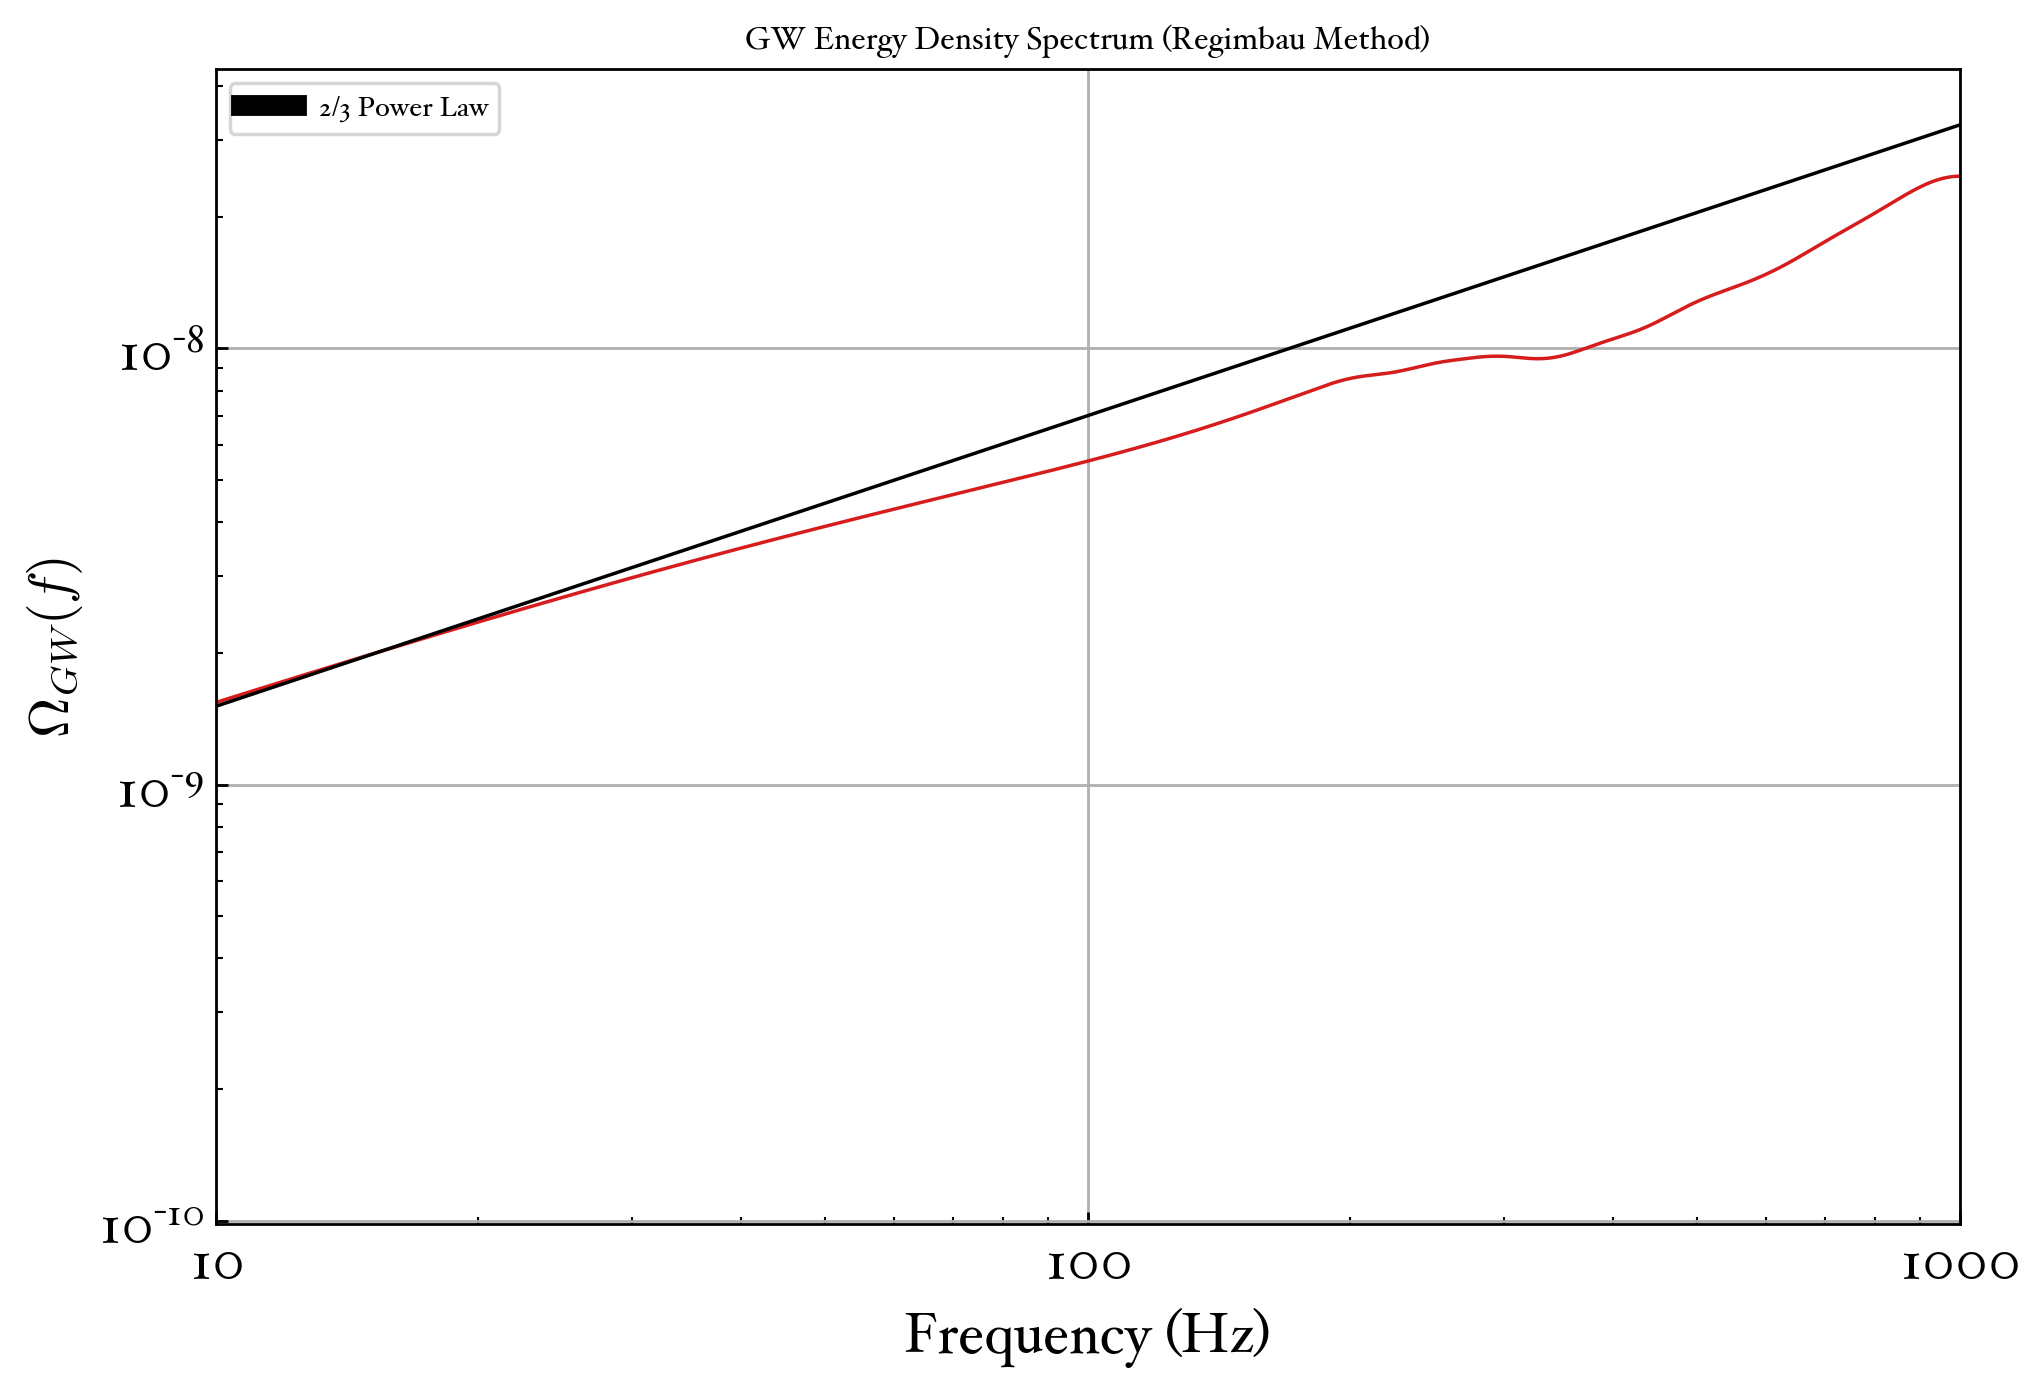

In [10]:
# Regimbau Method
num_iterations = 12 # number of iterations to average Omega(f) over
total_freqs_AR = []
total_OmegaGW_AR = []
total_Omega_ref_AR = 0
for i in range(num_iterations):
    # Create injections
    N_inj = np.random.poisson(N.value)
    injections = priors.sample(N_inj)
    injections["signal_type"] = 'CBC'
    print('Total number of injections: ' + str(N_inj))
    
    import json
    with open("test_CBC_injection_dict.json", "w") as outfile:
        json.dump(injections, outfile, indent=2, cls=bilby.core.result.BilbyJsonEncoder
    )
    
    # Initialize interferometers
    ifo_H1 = bilby.gw.detector.get_empty_interferometer('H1')
    ifo_L1 = bilby.gw.detector.get_empty_interferometer('L1')

    ifo_list = [ifo_H1, ifo_L1]

    for ifo in ifo_list: # iterate over interferometers
        ifo.duration = duration
        ifo.sampling_frequency = fs
        ifo.power_spectral_density = bilby.gw.detector.PowerSpectralDensity\
        (ifo.frequency_array, 1e-3*np.nan_to_num(ifo.power_spectral_density_array, posinf=1.e-41))
    
    # Simulate data
    simulator_cbc = Simulator(ifo_list, N_segs, duration=duration, injection_dict=injections,
                                           sampling_frequency=fs, no_noise=False)
    freqs_AR, OmegaGW_AR = simulator_cbc.compute_injected_Omega(return_spectrum=True, waveform_duration=4)
    Omega_ref = simulator_cbc.compute_injected_Omega(return_spectrum=False, waveform_duration=4)
    
    if i == 0:
        total_freqs_AR = freqs_AR
        total_OmegaGW_AR = OmegaGW_AR
        total_Omega_ref_AR = Omega_ref
    else:
        for j in range(len(freqs_AR)):
            total_freqs_AR[j] += freqs_AR[j]
            total_OmegaGW_AR[j] += OmegaGW_AR[j]
            
    total_Omega_ref_AR += Omega_ref
    
for i in range(len(total_freqs_AR)):
    total_freqs_AR[i] /= num_iterations
    total_OmegaGW_AR[i] /= num_iterations

total_Omega_ref_AR /= num_iterations
        
# Plot spectrum
plt.figure(figsize=(9, 6))
ax = plt.gca()
ax.loglog(total_freqs_AR, total_OmegaGW_AR, color='#d61c1c')
ax.loglog(total_freqs_AR, total_Omega_ref_AR*(total_freqs_AR/fref)**(2/3), label='2/3 Power Law', color='#000000')

ax.set_xlim(10, 1000)
ax.set_title(r'GW Energy Density Spectrum (Regimbau Method)')
ax.set_xlabel(r'Frequency (Hz)', fontsize=16)
ax.set_ylabel(r'$\Omega_{GW}(f)$', fontsize=16)
ax.legend(fontsize=16)
ax.tick_params(axis='both', labelsize=16)
ax.legend()

print('Omega_ref at 25 Hz: ' + format(Omega_ref, '.2e'))

In [ ]:
# Callister Method
# Set up OmegaGW object
inspiralOnly = False
m1_min = BBH_min
m1_max = BBH_max
m2_min = BBH_min
m2_max = BBH_max
minimum_component_mass = BBH_min
maximum_component_mass = BBH_max
omg = OmegaGW_BBH(minimum_component_mass, maximum_component_mass, zs)

# Calculate probability grid
# Priors defined in (m1, q) space
probs = np.empty((omg.m1s_2d.shape[0], omg.qs_2d.shape[1])) # initialize array
for i in range(omg.m1s_2d.shape[0]): # for each m1
    for j in range(omg.qs_2d.shape[1]): # for each q
        prob = priors.prob({'mass_1':omg.m1s_2d[i][j], 'mass_ratio':omg.qs_2d[i][j]}) # calculate probability
        probs[i][j] = prob # insert probability into probability array
probs = probs*(omg.Mtots_2d/(1. + omg.qs_2d)) # multiply by the Jacobian

# Limit probabilities to physical masses
probs[omg.m1s_2d < m1_min] = 0
probs[omg.m1s_2d > m1_max] = 0
probs[omg.m2s_2d < m2_min] = 0
probs[omg.m2s_2d > m2_max] = 0

# Normalize probabilities
probs /= np.sum(probs)
omg.probs = probs

# Calculate Omega(f)
freqs_TC = np.logspace(0, 3.2, 200)
OmegaGW_TC = omg.eval(R0, mergerRate, freqs_TC)
fref_approx_TC = 100
fref_approx_index_TC = 0
for i in range(len(freqs_TC)):
    if(np.absolute(freqs_TC[i] - fref) < fref_approx_TC):
        fref_approx_TC = np.absolute(freqs_TC[i] - fref)
        fref_approx_index_TC = i
Omega_ref_TC = OmegaGW_TC[fref_approx_index_TC]

# Plot
fig, ax = plt.subplots()
ax.loglog(freqs_TC, OmegaGW_TC, color='#7dd4fa')
ax.loglog(freqs_TC, Omega_ref_TC*(freqs_TC/fref)**(2/3), label='2/3 Power Law', color='#000000')
ax.set_title(r'GW Energy Density Spectrum (Callister Method)')
ax.set_xlabel(r'Frequency (Hz)')
ax.set_ylabel(r'$\Omega_{GW}(f)$')
ax.set_xlim(10, 1000)
ax.legend()
fig.show()

[10.         10.32020097 10.65065481 10.99168981 11.34364479
 11.7068694  12.08172449 12.46858249 12.86782771 13.2798568
 13.70507911 14.14391707 14.59680667 15.06419784 15.54655492
 16.04435712 16.55809899 17.08829093 17.63545967 18.2001488
 18.78291933 19.38435024 20.00503902 20.64560231 21.3066765
 21.98891835 22.69300566 23.4196379  24.16953699 24.94344791
 25.74213953 26.56640534 27.41706423 28.29496129 29.2009687
 30.13598655 31.10094377 32.09679901 33.12454164 34.18519268
 35.27980587 36.40946869 37.57530341 38.77846828 40.0201586
 41.30160797 42.62408947 43.98891696 45.39744635 46.851077
 48.35125304 49.89946486 51.49725057 53.14619754 54.84794395
 56.60418045 58.41665181 60.28715868 62.21755936 64.20977165
 66.26577478 68.38761133 70.57738929 72.83728416 75.16954108
 77.57647709 80.06048342 82.62402788 85.26965729 88.        ]
[0.11363636 0.1274858  0.14133523 0.15518466 0.16903409
 0.18288352 0.19673295 0.21058239 0.22443182 0.23828125
 0.25213068 0.26598011 0.27982955 0.2936

In [ ]:
# Combined Method
# Determine number of injections
N_inj = np.random.poisson(N.value)
injections = priors.sample(N_inj)
m1s = injections['mass_1']
qs = injections['mass_ratio']
m2s = []
Mtots = [] # m1 + m2
events = [] # array of chirp masses
for i in range(len(injections['mass_1'])):
    m2s.append(calculate_m2(m1s[i], qs[i]))
    Mtots.append(calculate_Mtot(m1s[i], m2s[i]))
    events.append(calculate_M(m1s[i], m2s[i]))

# Calculate Omega(f)
freqs_CB = []
OmegaGW_values_CB = []

for i in range(1, fs):
    f = i # frequency (in Hz)
    
    # Equation from Renzini et al. 2022.
    # Calculate the GW energy density by summing the spectral energy density from individual BBH events across redshift space.
    def integrand(z):
        f_ref = f*(1 + z)
        r = R_SI(alpha, beta, z, zp, R0)
        ave_dedf = ave_dEdf_SI(f_ref, Mtots, events)
        h = Hubble_rate_SI(z, H0, omegaR, omegaM, omegak, omegaL)
        return r*ave_dedf/((1 + z)*h)

    integral = scipy.integrate.quad(integrand, 0, z_max)
    OmegaGW = f/pc_SI(H0)*integral[0]
    freqs_CB.append(f)
    OmegaGW_values_CB.append(OmegaGW)

fref_approx_CB = 100
fref_approx_index_CB = 0
for i in range(len(freqs_CB)):
    if(np.absolute(freqs_CB[i] - fref) < fref_approx_CB):
        fref_approx_CB = np.absolute(freqs_CB[i] - fref)
        fref_approx_index_CB = i
Omega_ref_CB = OmegaGW_values_CB[fref_approx_index_CB]

# Plot
fig, ax = plt.subplots()
ax.loglog(freqs_CB, OmegaGW_values_CB, color='#25cc33')
ax.loglog(freqs_CB, Omega_ref_CB*(np.array(freqs_CB)/fref)**(2/3), label='2/3 Power Law', color='#000000')
ax.set_title(r'GW Energy Density Spectrum (Combined Method)')
ax.set_xlabel(r'Frequency (Hz)')
ax.set_ylabel(r'$\Omega_{GW}(f)$')
ax.set_xlim(10, 1000)
ax.legend()
fig.show()

In [ ]:
fig, ax = plt.subplots()
ax.loglog(total_freqs_AR, total_OmegaGW_AR, color='#d61c1c', label='Regimbau Method')
ax.loglog(freqs_TC, OmegaGW_TC, color='#7dd4fa', label='Callister Method')
ax.loglog(freqs_CB, OmegaGW_values_CB, color='#25cc33', label='Combined Method')
ax.loglog(total_freqs_AR, total_Omega_ref_AR*(total_freqs_AR/fref)**(2/3), label='2/3 Power Law (Regimbau)', color='#991414')
ax.loglog(freqs_TC, Omega_ref_TC*(freqs_TC/fref)**(2/3), label='2/3 Power Law (Callister)', color='#1f769c')
ax.loglog(freqs_CB, Omega_ref_CB*(np.array(freqs_CB)/fref)**(2/3), label='2/3 Power Law (Combined)', color='#14751c')
ax.set_title(r'GW Energy Density Spectrum')
ax.set_xlabel(r'Frequency (Hz)')
ax.set_ylabel(r'$\Omega_{GW}(f)$')
ax.set_xlim(10, 1000)
ax.legend()
fig.show()